Hasta aquí pudo correr
Start of evolution
  Evaluated 500 individuals
-- End of (successful) evolution --
Time Elapsed: 
93.560901

-- Punto final generado --
[ 0.96701899  0.99082247  2.05708292]
-- Punto final real --
[ 1.  1.  2.]
-- Error --
0.0044304338242
-- Energia --
3786.79736401


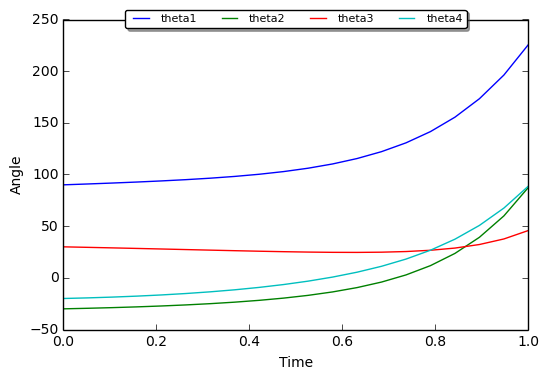

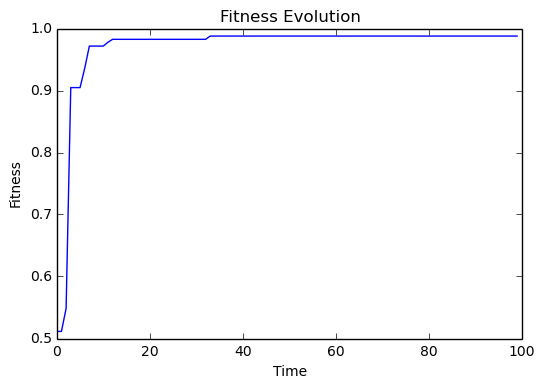

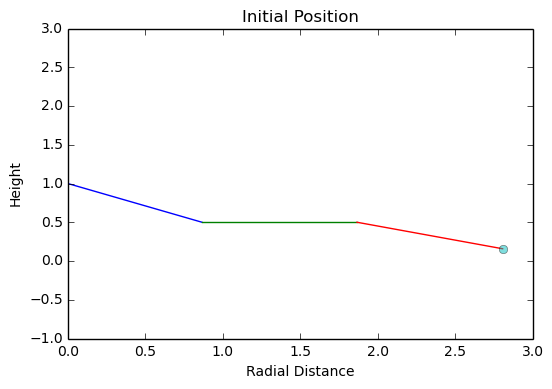

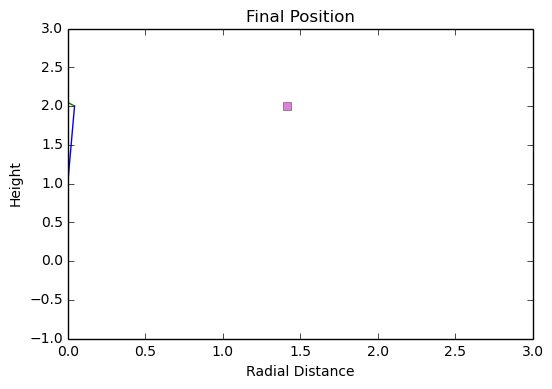

In [7]:
#GA con ajuste polinomial de grado 10 por cada angulo. 4x10-> 40 genes reales.
#Inicio aleatoria entre -20 y 20
from __future__ import division
from ThePablos import *
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import time
%matplotlib inline

####---------------------- PARAMETROS ---------------------- #####

#Arreglos para iterar
lam = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
Pmc = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]





#Posiciones en que se discretizan los caminos
Npos = 20
#Numero de generaciones
Ng = 100
#Numero de individuos en la poblacion
Npop = 500
#Duracion del movimiento
t_mov = 1
#Ponderacion de la energia en el fitness
lam = 0.01

n_coef = 10 #ind_size = 4*n_coef, grado 10

#Probabilidades de recombinacion y mutacion
Pci = 0.9 #cada individuo
Pcc = 0.9 #cada atributo
Pmi = 0.5
Pmc = 0.1

cotainf = np.array([-180,-90,-90,-90])*np.pi/180
cotamax = np.array([180,90,90,90])*np.pi/180
l1 = 1
l2 = 1
l3 = 1
l4 = 1
r = 1e-2

#configuracion inicial de angulos
condborde=np.array([90, -30, 30, -20])*np.pi/180

#Posicion target
#x,y,z plano cartesiano
#finalpos=np.array([1.93, 1.93, 1.0])
finalpos = np.array([1.0, 1.0, 2.0])
#finalpos=np.array([0, 0, 0])

#Crossover y MUt
eta_cx = 2 #SimulatedBinary
alpha_cx = 0.5 #Blend BLX-0.5
sigmaMut = 0.1


#Simulador de robot
robotArm = ThePablos(l1, l2, l3, l4, r, t_mov)


#FUNCIONES AUXILIARES
def checkBoundis(individual):
    global cotainf
    global cotamax
    thetaAux = getPathFromInd(individual) - condborde.reshape((4,1))
    cotainfAux = cotainf - condborde
    cotamaxAux = cotamax - condborde
    for i in range(4):
        factor = 1
        for k in range(Npos): 
            
            if thetaAux[i,k] > cotamaxAux[i]:
                factorTemp = cotamaxAux[i]/thetaAux[i,k]
                if factorTemp < factor: factor = factorTemp
                    
            elif thetaAux[i,k] < cotainfAux[i]:
                factorTemp = cotainfAux[i]/thetaAux[i,k]
                if factorTemp < factor: factor = factorTemp 
        individual[ i*n_coef:(i*n_coef+Npos)] = individual[i*n_coef:(i*n_coef+Npos)] *factor       
    return individual
    

def kernel(X,Y,sigma):
    return  np.exp( -sum((X-Y)**2) / (2*sigma**2) )


#CONVERTIR INDIVIDUO A TRAYECTORIA
def getPathFromInd(individual):
    global Npos
    global t_mov
    global condborde
    global n_coef    
    
    t1 = np.ones(Npos)*condborde[0]
    t2 = np.ones(Npos)*condborde[1]
    t3 = np.ones(Npos)*condborde[2]
    t4 = np.ones(Npos)*condborde[3]
    theta = np.vstack([t1,t2,t3,t4])
    for i in range(4):    
        for k in range(Npos):
            for j in range(0,n_coef):
                theta[i,k] += individual[i*n_coef+j]*((k*t_mov/Npos)**(j+1))
    return theta    

#Calculo del fitness a partir del path
def evaluatePath(theta):
    global finalpos
    global robotArm
    global lam
    global en_scale
    
    robotArm.setPath(theta[0], theta[1], theta[2], theta[3])
    robotArm.angularCons()
    finalGenerado = robotArm.endPoint()
    energia = robotArm.getEnergySim()
    
    fitness1 = mse(finalGenerado, finalpos)
    #fitness1 = 1/(1+mse(finalGenerado, finalpos))
    #fitness1 = kernel(finalGenerado, finalpos,5)
    
    fitness2 = energia
    #fitness2 = 1/(1+energia)
    #fitness2 = kernel(np.array([energia]), np.zeros(1),sigmaEnergy)
    
    return fitness,


#EVALUAR INDIVIDUO
def evaluate(individual):
    theta = getPathFromInd(individual)
    return evaluatePath(theta)

def kernel(X,Y,sigma):
    k =  np.exp(-sum((X-Y)**2) / 2*sigma**2)
    return k

def mse(x,y):
    return sum(abs((x-y)**2))
 

#Registro de fitness
#creator.create("FitnessMulti", base.Fitness, weights=(1.0,)) #maximizar
creator.create("FitnessMulti", base.Fitness, weights=(-1.0,)) #minimizar
creator.create("Individual", np.ndarray, fitness=creator.FitnessMulti)

#Asignacion de funciones para crear individuos
toolbox = base.Toolbox()
toolbox.register("attr_real", random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, n=4*n_coef)
#Un individuo es un arreglo de coeficientes

#Asignacion de funciones para crear la poblacion
toolbox.register("population", tools.initRepeat, list, toolbox.individual)    
    
#Asignacion de operadores    
toolbox.register("evaluate", evaluate)
#toolbox.register("mate", tools.cxBlend, alpha=alpha_cx)
toolbox.register("mate", tools.cxSimulatedBinary, eta=eta_cx)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=sigmaMut, indpb=Pmc)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("checki", checkBoundis)

print "Hasta aquí pudo correr"

####---------------------- ALGORITMO GENETICO ----------------------- #####


def main():
    startToooodo = time.clock()
    pop = toolbox.population(n=Npop)
    for ind in pop:
        toolbox.checki(ind)
    print("Start of evolution")
     # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    print("  Evaluated %i individuals" % len(pop))
    
    max1 = np.zeros(Ng)
    min1 = np.zeros(Ng)
    prom1 = np.zeros(Ng)
    max2 = np.zeros(Ng)
    min2 = np.zeros(Ng)
    prom2 = np.zeros(Ng)
    
    # Begin the evolution
    for g in range(Ng):
        
        #print("-- Generation %i --" % g)
        #start = time.clock()
        
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
        besties = tools.selBest(pop, 1)
        best1 = besties[0]
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            # cross two individuals with probability CXPB
            if random.random() < Pci:
                toolbox.mate(child1, child2)
                # fitness values of the children
                # must be recalculated later
                toolbox.checki(child1)
                toolbox.checki(child1)
                del child1.fitness.values
                del child2.fitness.values
        
        for mutant in offspring:
            #    mutate an individual with probability MUTPB
            if random.random() < Pmi:
                toolbox.mutate(mutant)
                toolbox.checki(mutant)
                del mutant.fitness.values
                
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit 
        
        #print("  Evaluated %i individuals" % len(invalid_ind))
         # The population is entirely replaced by the offspring
        pop[:] = offspring
        indaux = np.random.randint(0, len(pop))
        pop[indaux] = best1 #Elitismo
        
        fits1 = [ind.fitness.values[0] for ind in pop]
        #fits2 = [ind.fitness.values[1] for ind in pop]
        length = len(pop)
        max1[g]= np.max(fits1)
        #max2[g] = np.max(fits2)
        min1[g] = np.min(fits1)
        #min2[g] = np.min(fits2)
        prom1[g] = np.sum(fits1) /length
        #prom2[g] = np.sum(fits2)/ length
        
        #end = time.clock()
        #print "Time Elapsed: "
        #print(end-start)
        #print ""
    print("-- End of (successful) evolution --")
    
    best_ind = tools.selBest(pop, 1)[0]
    #print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    endToooodo = time.clock()
    print "Time Elapsed: "
    print(endToooodo-startToooodo)
    print ""
    #return best_ind, max1, max2, min1, min2, prom1, prom2
    return best_ind, max1, min1, prom1
    

####---------------------- VISUALIZACION DE RESULTADOS ----------------------- #####    
    

if __name__ == "__main__":
    #best, max1, max2, min1, min2, prom1, prom2 = main()
    best, max1, min1, prom1 = main()
    tiempo = np.linspace(0.0,t_mov,num=Npos)
    thetaWin = getPathFromInd(best)
    thetaWinA = thetaWin[0]
    thetaWinB = thetaWin[1]
    thetaWinC = thetaWin[2]
    thetaWinD = thetaWin[3]
    robotArm.setPath(thetaWinA, thetaWinB, thetaWinC, thetaWinD)
    robotArm.angularCons()
    
    #Trayectoria
    
    plt.figure(1)
    plt.plot(tiempo, thetaWinA*180/np.pi, label="theta1")
    plt.plot(tiempo, thetaWinB*180/np.pi, label="theta2")
    plt.plot(tiempo, thetaWinC*180/np.pi, label="theta3")
    plt.plot(tiempo, thetaWinD*180/np.pi, label="theta4")
    plt.xlabel("Time")
    plt.ylabel("Angle")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True, prop={'size':8})
    
    #Evolucion fitness
    
    lablox = range(Ng)
    plt.figure(2)
    #plt.subplot(211)
    plt.plot(lablox,max1, label = "Maximo")
    #plt.plot(lablox,min1, label = "Minimo")
    #plt.plot(lablox,prom1, label = "Promedio")
    plt.xlabel("Time")
    plt.ylabel("Fitness")
    plt.title("Fitness Evolution")
    #plt.legend(loc="lower left")
    
    #plt.subplot(212)
    #plt.plot(lablox,max2, label = "Maximo")
    #plt.plot(lablox,min2, label = "Minimo")
    #plt.plot(lablox,prom2, label = "Promedio")
    #plt.xlabel("Time")
    #plt.ylabel("Fitness2")
    #plt.title("Fitness Evolution")
    #plt.legend(loc="lower left")
    
    
    finalGenerado = robotArm.endPoint()
    energia = robotArm.getEnergySim()
    print("-- Punto final generado --")
    print finalGenerado
    print("-- Punto final real --")
    print finalpos
    print("-- Error --")
    print mse(finalGenerado,finalpos)
    print("-- Energia --")
    print energia
    
    #Posicion inicial robot
    plt.figure(3)
    puntitos = robotArm.getExtremos(0)
    dataR = puntitos[0]
    dataZ = puntitos[1]
    plots = [ plt.plot(dataR[i:i+2],dataZ[i:i+2]) for i in range(3)  ]
    plt.plot(dataR[-1],dataZ[-1],'o',alpha=0.5)
    plt.xlim([0,3])
    plt.ylim([-1,3])
    plt.xlabel("Radial Distance")
    plt.ylabel("Height")
    plt.title("Initial Position")
    
    #Posicion final robot
    plt.figure(4)
    puntitos = robotArm.getExtremos(-1)
    dataR = puntitos[0]
    dataZ = puntitos[1]
    plots = [ plt.plot(dataR[i:i+2],dataZ[i:i+2]) for i in range(3)  ]
    rDeseado = np.sqrt(finalpos[0]**2+finalpos[1]**2)
    zDeseado = finalpos[2]
    plt.plot(dataR[-1],dataZ[-1],'o',alpha=0.5)
    plt.plot(rDeseado,zDeseado,'s',alpha=0.5)
    plt.xlim([0,3])
    plt.ylim([-1,3])
    plt.xlabel("Radial Distance")
    plt.ylabel("Height")
    plt.title("Final Position")
    
    plt.show()


In [6]:
file = open("newfile.txt", "a")

file.write("This is a test\n")

file.write("And here is another line\n")

file.close()